In [1]:
import os 
import glob
import json
import numpy as np
import cv2

from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv2D,Flatten,Dropout,BatchNormalization,Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint


In [2]:
train_path='D:\\deep_learning_final\\train\\'
test_path="D:\\deep_learning_final\\test\\"
valid_path='D:\\deep_learning_final\\valid\\'

In [3]:
train_data=[image for image in os.listdir(train_path)]
test_data=[image for image in os.listdir(test_path)]
valid_data=[image for image in os.listdir(valid_path)]

In [4]:
train_annotation=glob.glob(os.path.join(train_path,"*.json"))
test_annotation=glob.glob(os.path.join(test_path,"*.json"))
valid_annotation=glob.glob(os.path.join(valid_path,"*.json"))


In [5]:
train_annotation=json.load(open(train_annotation[0]))
test_annotation=json.load(open(test_annotation[0]))
valid_annotation=json.load(open(valid_annotation[0]))


[ 808  890 1159]
[{'id': 808, 'license': 1, 'file_name': '2648_jpg.rf.016e6cc2890f6b9625a4ff84aa67dff6.jpg', 'height': 640, 'width': 640, 'date_captured': '2023-08-19T04:37:54+00:00'}, {'id': 890, 'license': 1, 'file_name': '1826_jpg.rf.0ec010d8ac523ef797621827928ca42f.jpg', 'height': 640, 'width': 640, 'date_captured': '2023-08-19T04:37:54+00:00'}, {'id': 1159, 'license': 1, 'file_name': '1425_jpg.rf.6bc5ba0067c739342a37f04b78c381ce.jpg', 'height': 640, 'width': 640, 'date_captured': '2023-08-19T04:37:54+00:00'}]
[{'id': 808, 'image_id': 808, 'category_id': 1, 'bbox': [268, 204, 87.5, 118.75], 'area': 10390.625, 'segmentation': [[355, 203.75, 267.5, 203.75, 267.5, 322.5, 355, 322.5, 355, 203.75]], 'iscrowd': 0}, {'id': 890, 'image_id': 890, 'category_id': 2, 'bbox': [299, 196, 167.5, 135], 'area': 22612.5, 'segmentation': [[466.25, 196.25, 298.75, 196.25, 298.75, 331.25, 466.25, 331.25, 466.25, 196.25]], 'iscrowd': 0}, {'id': 1159, 'image_id': 1158, 'category_id': 2, 'bbox': [311, 281

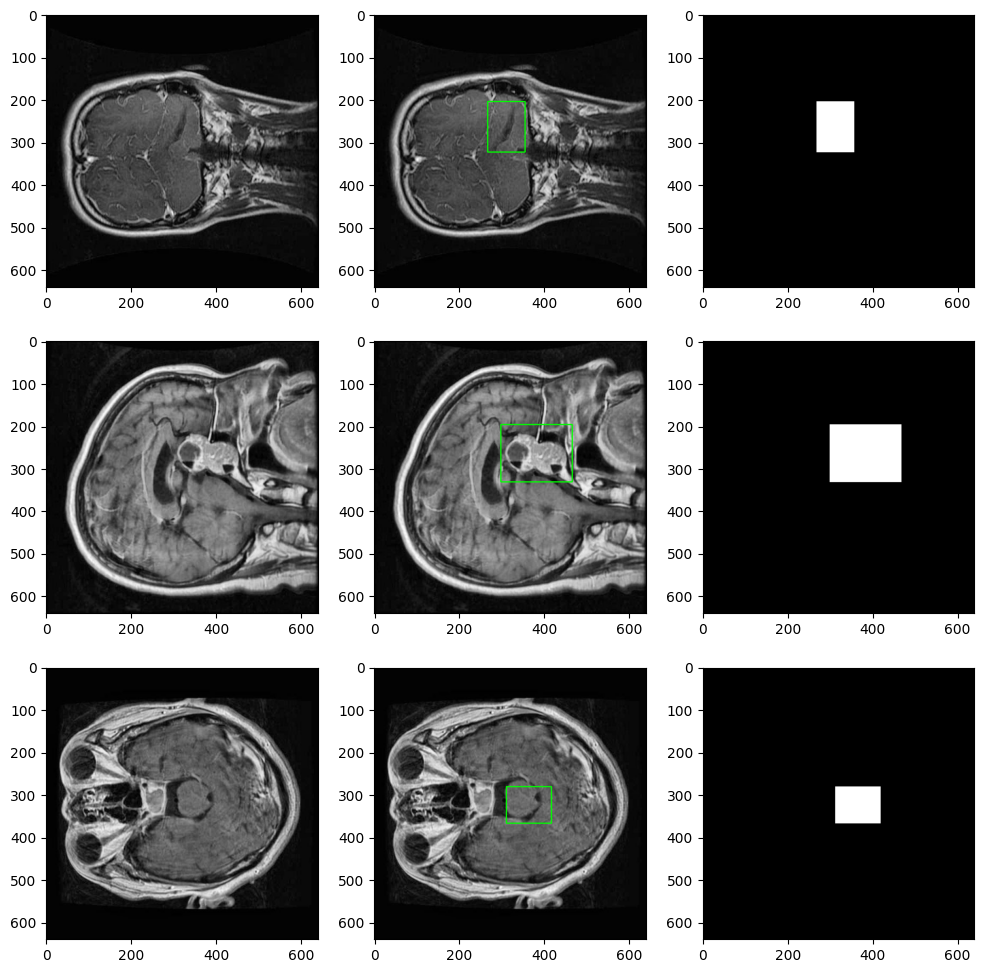

In [6]:
def visualize_random_images(n=3): # select n random images

  # use cv and plt to show these images
  indices = np.random.randint(0, len(train_annotation['images']), size=n)
  print(indices)

  #Image and Annotation Retrieval:
  images =[train_annotation['images'][i] for i in indices ]
  annotations = [train_annotation['annotations'][i] for i in indices ]
  print(images)
  print(annotations)
    
  j=1
  plt.figure(figsize=(12, 2 * 2 * n))
  for img,ann in zip(images,annotations):
    
    # 原圖片
    plt.subplot(n,3,j)
    j+=1
    image = cv2.imread(train_path + img['file_name'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    
    # 腫瘤範圍
    # create masked images from annotations
    segmentation = ann['segmentation']
    segmentation = np.array(segmentation[0], dtype=np.int32).reshape(-1, 2) #convert 1D into 2D
    # print(segmentation)

    cv2.polylines(image, [segmentation], isClosed=True, color=(0, 255, 0), thickness=2)  # Green color with thickness 2

    plt.subplot(n,3,j)
    plt.imshow(image)
    j+=1
    
    # 遮罩圖片
    mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    cv2.fillPoly(mask, [segmentation], color=1)
    plt.subplot(n,3,j)
    plt.imshow(mask,cmap='gray')
    j+=1

visualize_random_images()

In [7]:
def _train_masks():
    print('train masks')
    mask_dir = 'D:\\deep_learning_final\\train_masks\\'
    os.makedirs(mask_dir, exist_ok=True)
    totalImages = len(train_annotation['images'])
    done = 0
    for img,ann in zip(train_annotation['images'],train_annotation['annotations']):
        path = train_path + img['file_name']
        mask_path = mask_dir + img['file_name']
        # load image in open cv
        image = cv2.imread(path)
        segmentation = ann['segmentation']
        segmentation = np.array(segmentation[0], dtype=np.int32).reshape(-1, 2)
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        cv2.fillPoly(mask, [segmentation], color=(255,255,255))
        cv2.imwrite(mask_path, mask)
        done+=1
    print(f"train  {done} / {totalImages} ")

def _test_masks():
    print('test masks')

    totalImages = len(test_annotation['images'])
    done = 0
    mask_dir = 'D:\\deep_learning_final\\test_masks\\'
    os.makedirs(mask_dir, exist_ok=True)
    
    for img,ann in zip(test_annotation['images'],test_annotation['annotations']):
        path = test_path + img['file_name']
        mask_path = mask_dir + img['file_name']
        # load image in open cv
        image = cv2.imread(path)
        segmentation = ann['segmentation']
        segmentation = np.array(segmentation[0], dtype=np.int32).reshape(-1, 2)
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        cv2.fillPoly(mask, [segmentation], color=(255,255,255))
        cv2.imwrite(mask_path, mask)
        done+=1

    print(f"test  {done} / {totalImages} ")


def _val_masks():
    print('val masks')
    totalImages = len(valid_annotation['images'])
    done = 0
    mask_dir = 'D:\\deep_learning_final\\val_masks\\'
    os.makedirs(mask_dir, exist_ok=True)
    
    for img,ann in zip(valid_annotation['images'],valid_annotation['annotations']):
        path = valid_path + img['file_name']
        mask_path = mask_dir + img['file_name']
        # load image in open cv
        image = cv2.imread(path)
        segmentation = ann['segmentation']
        segmentation = np.array(segmentation[0], dtype=np.int32).reshape(-1, 2)
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        cv2.fillPoly(mask, [segmentation], color=(255,255,255))
        cv2.imwrite(mask_path, mask)
        done+=1
    print(f"val  {done} / {totalImages} ")


from threading import Thread
def make_masks():
  threads = []
  threads.append( Thread(target=_train_masks))

  threads.append( Thread(target=_test_masks))

  threads.append( Thread(target=_val_masks))
  for t in threads:
    t.start()
  for t in threads:
    t.join()
  print('complete')
  return

make_masks()

train masks
test masks
val masks
test  215 / 215 
val  429 / 429 
train  1502 / 1502 
complete


In [8]:
def load_data():
    target_size = (128, 128)
    train_mask_dir = 'D:\\deep_learning_final\\train_masks\\'
    
    X_train =  [cv2.resize(cv2.imread(train_path + image['file_name']),target_size) for image in train_annotation['images']]
    y_train = [cv2.resize(cv2.imread(train_mask_dir + image['file_name'],cv2.IMREAD_GRAYSCALE),target_size ) for image in train_annotation['images']]
    X_train = np.array(X_train)
    y_train = np.expand_dims(np.array(y_train), axis=-1)
    
    X_train = X_train.astype('float32') / 255.0
    y_train = y_train.astype('float32') / 255.0
    y_train = (y_train > 0.5).astype(np.float32)
    
    

    

    val_mask_dir = 'D:\\deep_learning_final\\val_masks\\'
    X_val =  [cv2.resize(cv2.imread(valid_path + image['file_name']),target_size) for image in valid_annotation['images']]
    y_val = [cv2.resize(cv2.imread(val_mask_dir + image['file_name'],cv2.IMREAD_GRAYSCALE),target_size) for image in valid_annotation['images']]
    X_val = np.array(X_val)
    y_val = np.expand_dims(np.array(y_val), axis=-1)

    X_val = X_val.astype('float32') / 255.0
    y_val = y_val.astype('float32') / 255.0
    y_val = (y_val > 0.5).astype(np.float32)
    
    return X_train,y_train,X_val,y_val



def load_test_data():
    target_size = (128, 128)

    test_mask_dir = 'D:\\deep_learning_final\\test_masks\\'
    X_test =  [cv2.resize(cv2.imread(test_path + image['file_name']),target_size) for image in test_annotation['images']]
    y_test = [cv2.resize(cv2.imread(test_mask_dir + image['file_name'],cv2.IMREAD_GRAYSCALE),target_size) for image in test_annotation['images']]
    X_test = np.array(X_test)
    y_test = np.expand_dims(np.array(y_test), axis=-1)

        
    X_test = X_test.astype('float32') / 255.0
    y_test = y_test.astype('float32') / 255.0
    y_test = (y_test > 0.5).astype(np.float32)
    return X_test,y_test

X_train,y_train,X_val,y_val = load_data()

In [9]:
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x


def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f, p


def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 2, 2, padding="same")(x) # 3,2
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.4)(x) # 0.3
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

In [10]:
def build_unet_model():

    # inputs
    inputs = layers.Input(shape=(128,128,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # # 5 - downsample
    # f5, p5 = downsample_block(p4, 1024)

    # 6 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample

    # # 7 - upsample
    # u6 = upsample_block(bottleneck, f5, 1024)

    # 6 - upsample
    u7 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u8 = upsample_block(u7, f3, 256)
    # 8 - upsample
    u9 = upsample_block(u8, f2, 128)
    # 9 - upsample
    u10 = upsample_block(u9, f1, 64)

    # outputs
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(u10)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [11]:
unet_model = build_unet_model()

unet_model.compile(optimizer="adam",loss="BinaryCrossentropy",metrics=["accuracy"])

unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [12]:
from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor='val_loss',patience=5)

callbacks_list = [earlystop]

unet_model.fit(X_train,y_train,epochs=100,validation_data=(X_val,y_val),callbacks=callbacks_list)

Epoch 1/100
47/47 [==============================] - 27s 370ms/step - loss: 2.3562 - accuracy: 0.9501 - val_loss: 0.3058 - val_accuracy: 0.9627
Epoch 2/100
47/47 [==============================] - 11s 233ms/step - loss: 0.1893 - accuracy: 0.9627 - val_loss: 0.1294 - val_accuracy: 0.9627
Epoch 3/100
47/47 [==============================] - 11s 233ms/step - loss: 0.1296 - accuracy: 0.9628 - val_loss: 0.1232 - val_accuracy: 0.9627
Epoch 4/100
47/47 [==============================] - 11s 234ms/step - loss: 0.1188 - accuracy: 0.9628 - val_loss: 0.1124 - val_accuracy: 0.9627
Epoch 5/100
47/47 [==============================] - 11s 234ms/step - loss: 0.1125 - accuracy: 0.9628 - val_loss: 0.1120 - val_accuracy: 0.9627
Epoch 6/100
47/47 [==============================] - 11s 234ms/step - loss: 0.1102 - accuracy: 0.9628 - val_loss: 0.1117 - val_accuracy: 0.9627
Epoch 7/100
47/47 [==============================] - 11s 237ms/step - loss: 0.1092 - accuracy: 0.9628 - val_loss: 0.1095 - val_accuracy:

In [13]:
def predict(image_path, model, threshold=0.5):
    
    # Read and preprocess the image
    image = cv2.imread(image_path)
    # print("Original Image Shape:", image.shape)
    
    # Resize the image to match model's expected sizing
    resized_image = cv2.resize(image, (128, 128))
    # print("Resized Image Shape:", resized_image.shape)
    
    # Expand dimensions to match the batch size used by the model
    input_image = np.expand_dims(resized_image, axis=0)
    
    # Preprocess input (normalize to [0, 1] range)
    input_image = input_image.astype('float32') / 255.0
    
    # Perform prediction
    pred_mask = model.predict(input_image)
    
    # Apply threshold to prediction mask
    pred_mask[pred_mask >= threshold] = 1  # set values >= threshold to 1 (foreground)
    pred_mask[pred_mask < threshold] = 0   # set values < threshold to 0 (background)
    
    # If your model outputs probabilities, you might need to squeeze the mask
    pred_mask = np.squeeze(pred_mask, axis=0)
    
    # # Count number of pixels where mask is 1 (foreground)
    # num_pixels = np.count_nonzero(pred_mask)
    
    print("shape mask",pred_mask.shape)
    return pred_mask

shape mask (128, 128, 1)
shape mask (128, 128, 1)
shape mask (128, 128, 1)
shape mask (128, 128, 1)
shape mask (128, 128, 1)


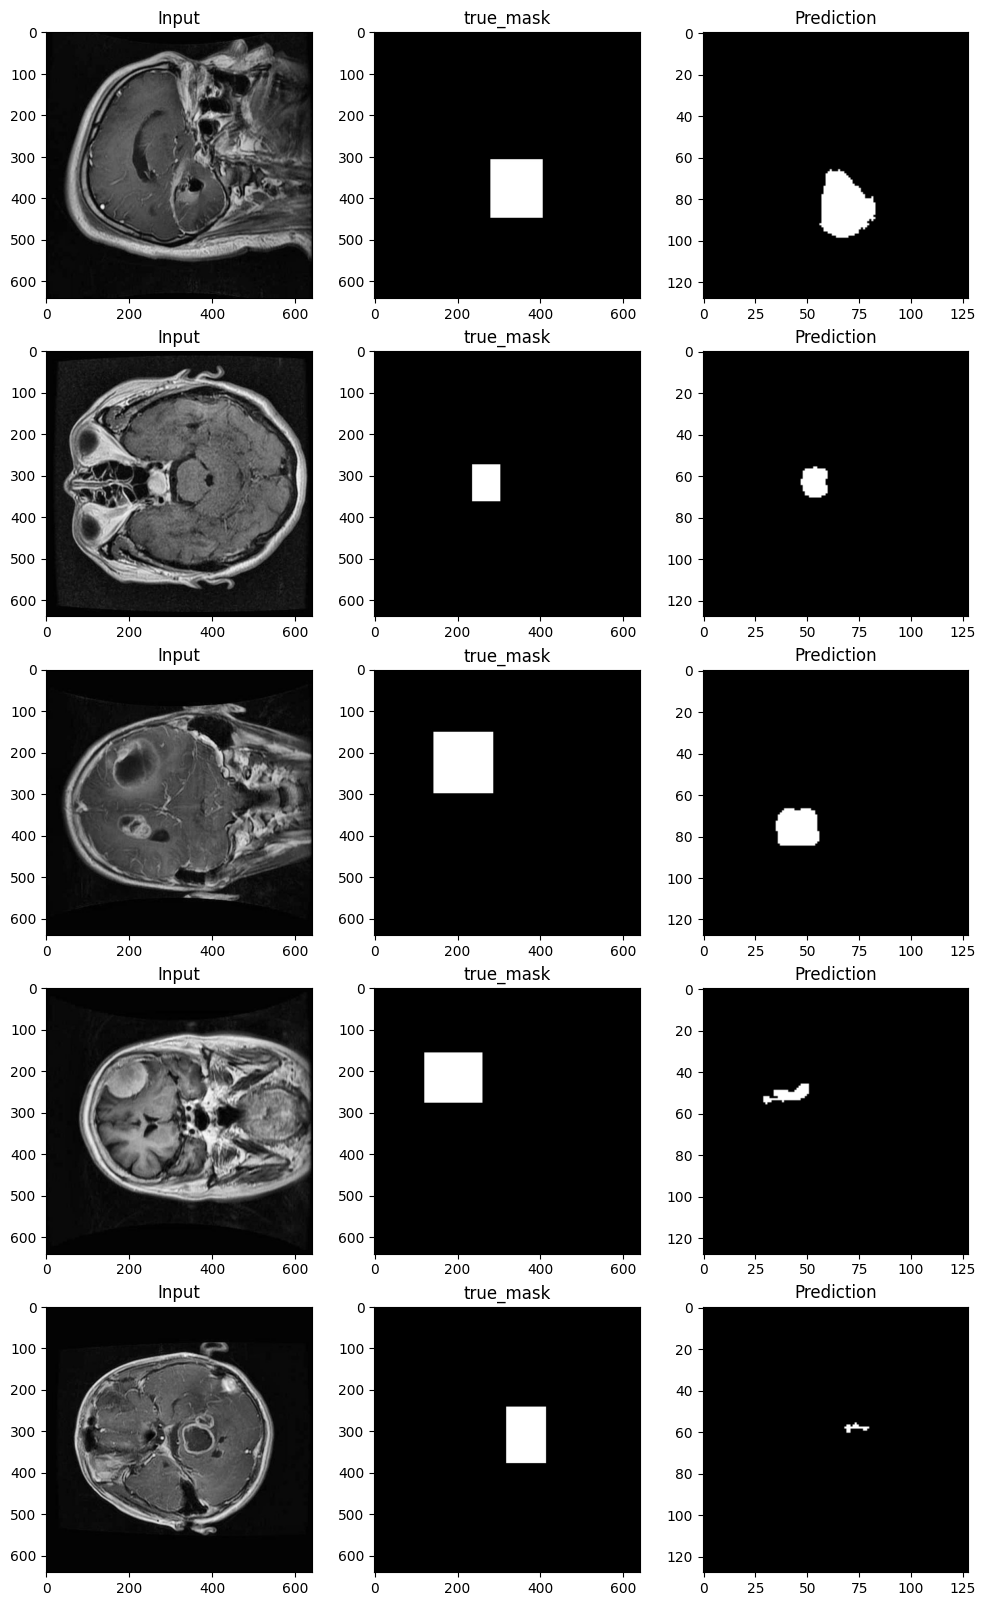

In [14]:
def test_random_images(n=5):
  # select n random images
  # use cv and plt to show these images
    test_mask_dir = 'D:\\deep_learning_final\\test_masks\\'

    indices = np.random.randint(0, len(test_annotation['images']), size=n)

    images =[test_annotation['images'][i] for i in indices ]

    annotations = [test_annotation['annotations'][i] for i in indices ]
    j=1
    plt.figure(figsize=(12, 2 * 2 * n))
    for img,ann in zip(images,annotations):
        plt.subplot(n,3,j)
        j+=1
        image = cv2.imread(test_path + img['file_name'])
        
        plt.imshow(image)
        plt.title("Input")

        mask = predict(test_path + img['file_name'],unet_model)
        
        result_image = np.zeros((128, 128,1), dtype=np.uint8)
        result_image[mask == 1] = 255
        
        true_mask = cv2.imread(test_mask_dir + img['file_name'])
        
        plt.subplot(n,3,j)
        j+=1
        plt.imshow(true_mask)
        plt.title("true_mask")
        
        plt.subplot(n,3,j)
        j+=1
        plt.imshow(result_image,cmap='gray')
        plt.title("Prediction")

test_random_images()